In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
import architectures
import importlib


### Image generation with non-variational autoencoder

In [72]:
rnae_filepaths = sorted([f for f in os.listdir() if f[:4] == 'rnae'], reverse=True)
rnae_fp = rnae_filepaths[0]
mrnae_filepaths = sorted([f for f in os.listdir() if f[:5] == 'mrnae'], reverse=True)
mrnae_fp = mrnae_filepaths[0]

print(rnae_fp, mrnae_fp)
mrnae = architectures.MnistResNetAutoEncoder()
mrnae.load_state_dict(torch.load('mrnae_20250802_083036.pt'))

rnae_20250802_053836.pt mrnae_20250802_083036.pt


<All keys matched successfully>

In [73]:
from torchvision import datasets, transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize pixel values
])
mnist_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=1000, shuffle=False)

In [74]:
embds = []
for idx, batch in enumerate(mnist_test_loader):
  embd, repr = mrnae(batch[0])
  embds.append(embd)

embd_all = torch.cat(embds)

In [75]:
embd_mu = embd_all.mean(dim=0)
embd_sig = embd_all.std(dim=0)

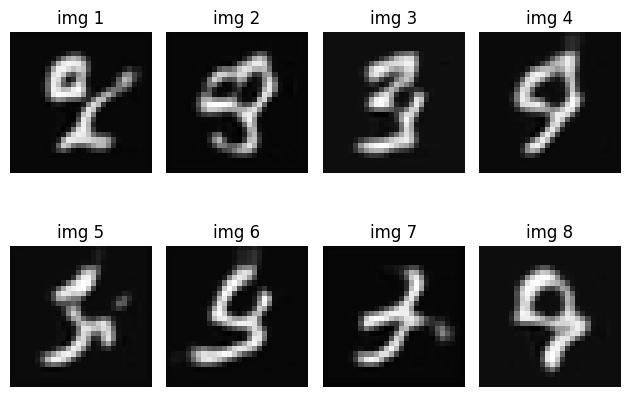

In [76]:
samples = [torch.normal(mean=embd_mu, std=embd_sig) for i in range(8)]
imgs = [mrnae.decode(s.unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy() for s in samples]

fig, axes = plt.subplots(nrows=2, ncols=4)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i], cmap='gray')
    ax.set_title(f'img {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Training a VAE

In [80]:
importlib.reload(architectures)

mvae = architectures.MnistResNetVAE()

# use pre-trained encoder and decoder, except for final linear projection into embedding space
mvae.resnet = nn.Sequential(*list(mrnae.resnet.children())[:-1])
mvae.unresnet = nn.Sequential(*list(mrnae.unresnet.children()))

# don't update gradients for these
for param in mvae.resnet.parameters():
  param.requires_grad = False
for param in mvae.unresnet.parameters():
  param.requires_grad = False

In [81]:
for idx, batch in enumerate(mnist_test_loader):
  mvae(batch[0])